# Task 2&3

Frederik Rogge, Mouhammad Abu Rasheed and Homa Priya Tarigopula

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
import os
%matplotlib inline

from utils import *


In [2]:
# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)


# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))


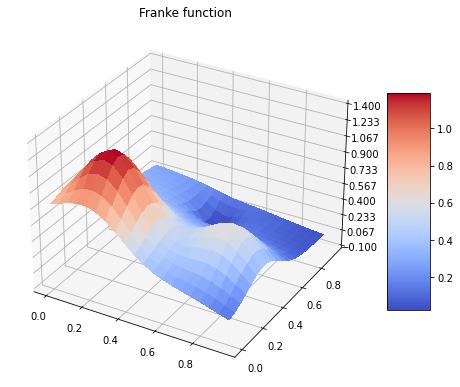

In [3]:
def plot_function(x, y, z, title=None):
    # Plot function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title is not None:
        plt.title(title)
    
    plt.show()
    
plot_function(x, y, z, 'Franke function')

### Part b) : Bias Variance trade-off on Franke function

#### Refer task 1 for MSE as a function of complexity 

### Part b) : Bootstrap Resampling technique

In [4]:
def bootstrap(features, labels , k_values, degree_values, 
                              scaling= True , add_noise= True, mean = 0, std = 1):
  
    Maxpolydegree = np.max(degree_values)
    error_test = np.zeros((Maxpolydegree,  len(k_values)))
    bias_test = np.zeros((Maxpolydegree,  len(k_values)))
    variance_test = np.zeros((Maxpolydegree,  len(k_values)))

    error_train = np.zeros((Maxpolydegree,  len(k_values)))
    bias_train = np.zeros((Maxpolydegree,  len(k_values)))
    variance_train = np.zeros((Maxpolydegree,  len(k_values)))



    if add_noise :
        np.random.seed(1)
        labels = labels +  np.random.normal(mean, std, labels.shape )
    if scaling :
        features = z_score(features)

    n_boostraps = 1000

    for n,k in enumerate(k_values) :
        # Hold out some test data that is never used in training.
        x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                            test_size=1/k, random_state = 2021)
    
        for nd, degree in enumerate(degree_values):
            # Input features transformation 
            poly = PolynomialFeatures(degree = degree)
            X_train_poly= poly.fit_transform(x_train)
            X_test_poly= poly.fit_transform(x_test)

            # The following (m x n_bootstraps) matrix holds the column vectors y_pred
            # for each bootstrap iteration.
            y_pred = np.empty((y_test.shape[0], n_boostraps))   ## test set
            y_pred_train = np.empty((y_train.shape[0], n_boostraps))   ## train set

            for i in range(n_boostraps):
                x_, y_ = resample(X_train_poly, y_train)
                # Evaluate the new model on the same test data each time.
                beta = OLS_linearReg(x_, y_)
                y_pred_train[:, i] = X_train_poly @ beta.ravel()
                y_pred[:, i] = X_test_poly @ beta.ravel()

            #compute error, bias^2 and variance 
            error_test[nd,n] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
            bias_test[nd,n] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
            variance_test[nd,n] = np.mean( np.var(y_pred, axis=1, keepdims=True) )

            error_train[nd,n] = np.mean( np.mean((y_train - y_pred_train)**2, axis=1, keepdims=True) )
            bias_train[nd,n] = np.mean( (y_train - np.mean(y_pred_train, axis=1, keepdims=True))**2 )
            variance_train[nd,n] = np.mean( np.var(y_pred_train, axis=1, keepdims=True) )

    return error_test, bias_test, variance_test,error_train , bias_train , variance_train 



In [5]:
def gen_plot_bootstrap(k_values, polynomial, estimated_mse, title , y_label, legend_label):
    for n,k in enumerate(k_values):
        plt.plot(polynomial, estimated_mse[:, n], label= legend_label +'size = '+str(np.round(1/k, 2))+', k = '+ str(k)  )
        plt.xlabel('Polynomial degree')
        plt.ylabel( y_label)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()

#### Bootstrap bias variance tradeoff


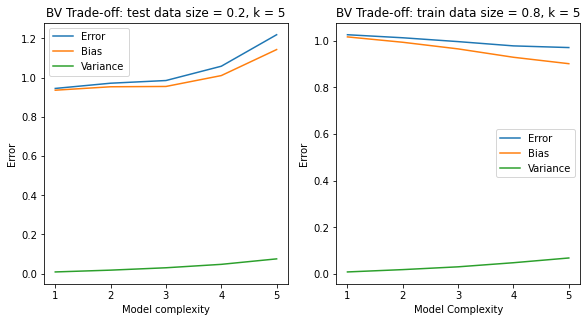

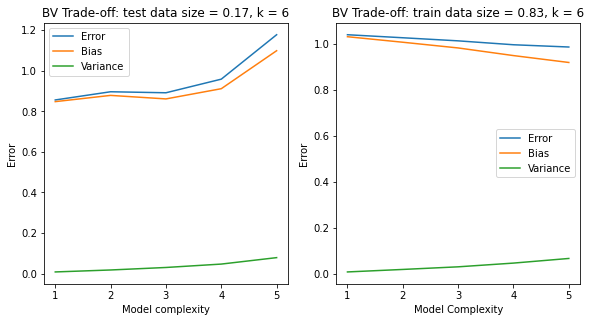

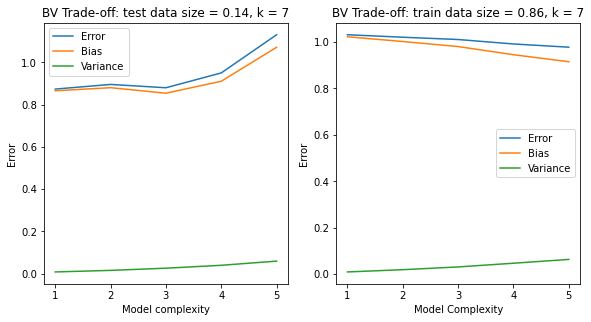

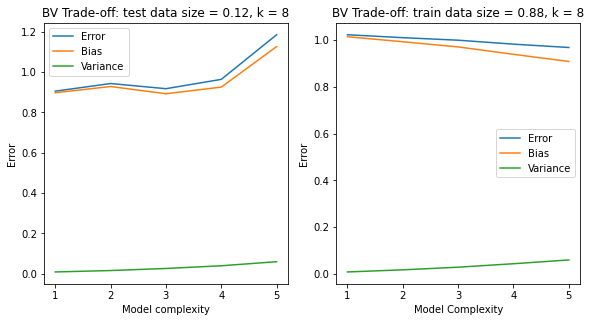

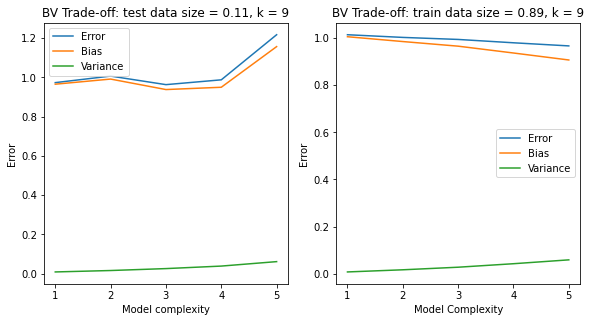

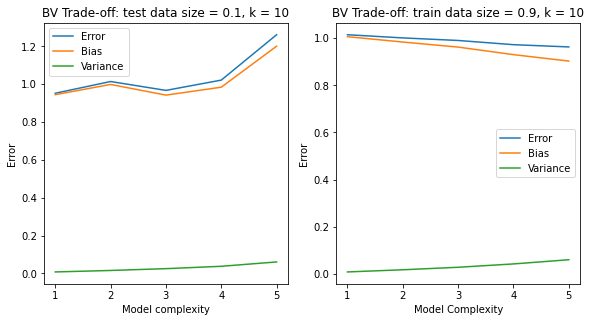

In [6]:
k_values  = [5, 6, 7, 8, 9, 10]  # Number of folds
degree_values = np.arange(1, 6)  # Specify degree of polynomial to be fitted

error_test, bias_test, variance_test,error_train , bias_train , variance_train = bootstrap(features, labels , k_values, degree_values, 
                              scaling= True , add_noise= True, mean = 0, std = 1)
Maxpolydegree = np.max(degree_values)
polynomial = np.zeros(Maxpolydegree)

for polydegree in range(1, Maxpolydegree+1):
    polynomial[polydegree-1] = polydegree

    
# plot bias-variance tradeoff
for n,k in enumerate(k_values): 
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(4.8*2, 4.8))
    ax0.plot(polynomial, error_test[:, n], label= 'Error')
    ax0.plot(polynomial, bias_test[:, n], label= 'Bias')
    ax0.plot(polynomial, variance_test[:, n], label= 'Variance')
    ax0.set_xlabel('Model complexity')
    ax0.set_ylabel('Error')
    ax0.legend()
    ax0.set_title('BV Trade-off: test data size = '+str(np.round(1/k, 2))+', k = '+ str(k))

    ax1.plot(polynomial, error_train[:, n], label= 'Error')
    ax1.plot(polynomial, bias_train[:, n], label= 'Bias')
    ax1.plot(polynomial, variance_train[:, n], label= 'Variance')
    ax1.set_xlabel('Model Complexity')
    ax1.set_ylabel('Error')
    ax1.legend()
    ax1.set_title('BV Trade-off: train data size = '+str(np.round(1-1/k, 2))+', k = '+ str(k))
  



#### Bootstrap Error with respect to complexity and datasize for train and test data

In [8]:
def plot_bootstrap(features, labels , k_values, degree_values, 
                              scaling= True , add_noise= True, mean = 0, std = 1):
    Maxpolydegree = np.max(degree_values)
    polynomial = np.zeros(Maxpolydegree)

    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = polydegree

    error_test, bias_test, variance_test,error_train , bias_train , variance_train = bootstrap(features, labels , k_values, degree_values, 
                              scaling= True , add_noise= True, mean = 0, std = 1)

    # generating plots
    gen_plot_bootstrap(k_values, polynomial, error_train,
                 title = 'Bootstrap error for Train data', 
                 y_label = 'Error',
                 legend_label = 'Train data')


    gen_plot_bootstrap(k_values, polynomial, error_test,
                 title = 'Bootstrap error for Test data', 
                 y_label = 'Error',
                 legend_label = 'Test data')
  
  
    

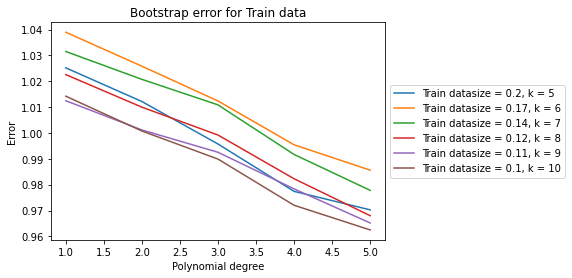

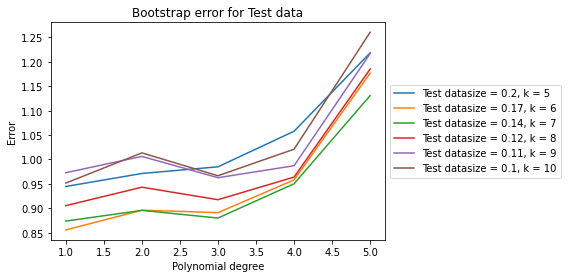

In [9]:
k_values  = [5, 6, 7, 8, 9, 10]  # Number of folds
degree_values = [1, 2, 3, 4, 5]  # Specify degree of polynomial to be fitted

plot_bootstrap(features, labels ,k_values, degree_values) 

## Part c) : Cross validation as resampling techniques

In [10]:
def gen_plot_kfold(k_values, polynomial, estimated_mse, title , legend_label):
    for n,k in enumerate(k_values): 
        plt.plot(polynomial, estimated_mse[:, n], label= legend_label +' '+str(k)+' folds' )
        plt.xlabel('Polynomial degree')
        plt.ylabel('MSE')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()

### K-fold cross validation

In [11]:
def plot_kfold_implementation(features, labels , k_values, degree_values, 
                              scaling= True , add_noise= True, mean = 0, std = 1):
    Maxpolydegree = np.max(degree_values)
    polynomial = np.zeros(Maxpolydegree)
    estimated_train_mse = np.zeros((Maxpolydegree,  len(k_values)))
    estimated_test_mse = np.zeros((Maxpolydegree,len(k_values)))

    if add_noise :
        np.random.seed(1)
        labels = labels +  np.random.normal(mean, std, labels.shape )
    if scaling :
        features = z_score(features)

    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = polydegree

    for degree in degree_values:
        for n,k in enumerate(k_values):
            kfold = KFold(n_splits = k)  # Splitting into folds
            train_MSE = np.zeros(k)
            test_MSE = np.zeros(k)
            
            # iterate over the folds, leaving one fold out for testing each time
            for nk,(train_index, test_index) in enumerate(kfold.split(features)):
                X_train, X_test = features[train_index], features[test_index]
                y_train, y_test = labels[train_index], labels[test_index]
                
                # fit polynomials on test and train
                poly = PolynomialFeatures(degree)
                X_train_poly= poly.fit_transform(X_train)
                X_test_poly= poly.fit_transform(X_test)   
                
                # find model params 'beta' using OLS
                beta= OLS_linearReg(X_train_poly, y_train)

                y_hat_train = X_train_poly @ beta
                y_hat_test = X_test_poly @ beta

                train_MSE[nk] = MSE(y_hat_train  , y_train)
                test_MSE[nk] = MSE(y_hat_test  , y_test)

            estimated_train_mse[degree-1, n] = np.mean(train_MSE)
            estimated_test_mse[degree-1, n] = np.mean(test_MSE)

    print('MSE on test-set : \n',estimated_test_mse)

    gen_plot_kfold(k_values, polynomial, estimated_train_mse, title = 'k-fold cv implementation for different order polynomials' ,
                legend_label = 'Train Error')

    gen_plot_kfold(k_values, polynomial, estimated_test_mse, title = 'k-fold cv implementation for different order polynomials' ,
                legend_label = 'Test Error')
    





#### With noise


MSE on test-set : 
 [[1.04759816 1.03621876 1.03795371 1.03080425 1.03235299 1.03504525]
 [1.08591581 1.04989276 1.08745607 1.0706907  1.0631547  1.06162568]
 [1.07683354 1.06764979 1.03957293 1.04108477 1.04012806 1.03315463]
 [1.54945564 1.24732393 1.31723977 1.3770104  1.28059704 1.09536324]
 [3.10272612 1.39434358 2.20685684 2.54751803 2.04617254 1.28492129]]


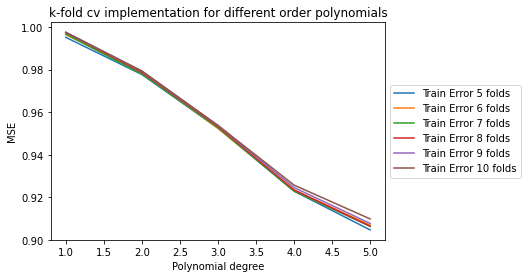

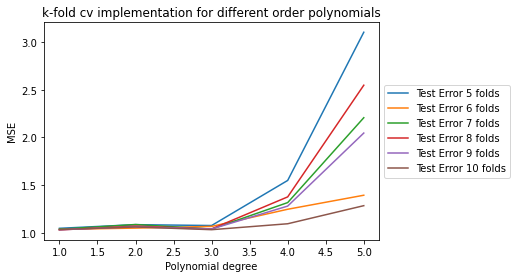

In [12]:
k_values  = [5, 6, 7, 8, 9, 10]  # Number of folds
degree_values = [1, 2, 3, 4, 5]   # Specify degree of polynomial to be fitted

plot_kfold_implementation(features, labels ,k_values, degree_values) 

#### Without noise

MSE on test-set : 
 [[0.04576671 0.03874027 0.03839682 0.03467602 0.03352505 0.03379264]
 [0.11228997 0.0684227  0.05652764 0.04264218 0.03974759 0.03686937]
 [0.01820134 0.01337367 0.01286016 0.01229501 0.01220757 0.0111079 ]
 [0.09289967 0.04102599 0.02131225 0.01729308 0.01635007 0.01698624]
 [0.13528561 0.03653383 0.02653421 0.00997742 0.00951974 0.01010605]]


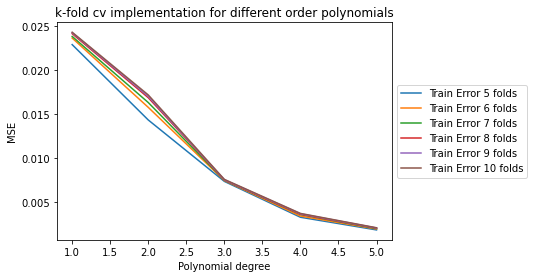

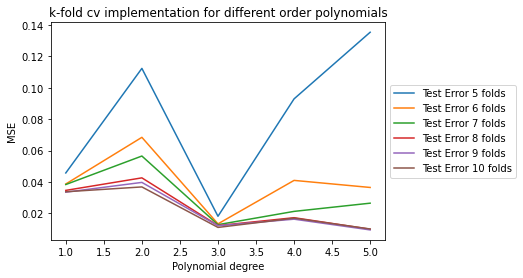

In [13]:
k_values  = [5, 6, 7, 8, 9, 10]  # Number of folds
degree_values = [1, 2, 3, 4, 5]    # Specify degree of polynomial to be fitted

plot_kfold_implementation(features,labels , k_values, degree_values, scaling= True, add_noise= False) 


### K-fold cross validation with scikit learn 

In [14]:
def plot_Kfold_scikit(features,labels , k_values, degree_values, scaling= True , add_noise= True, mean = 0, std = 1):
    Maxpolydegree = np.max(degree_values)
    estimated_mse_sklearn = np.zeros((Maxpolydegree, len(k_values)))
    polynomial = np.zeros(Maxpolydegree)

    if add_noise :
        np.random.seed(1)
        labels = labels + np.random.normal(mean, std, labels.shape)
    if scaling :
        features = z_score(features)

    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = int(polydegree)

    for n,k in enumerate(k_values):
        for degree in degree_values:
            poly = PolynomialFeatures(degree)
            X_poly= poly.fit_transform(features)
            OLS = LinearRegression(fit_intercept=False)
            # loop over folds in order to estimate the expectation value of the MSE
            estimated_mse_folds = cross_val_score(OLS, X_poly, labels, scoring='neg_mean_squared_error', cv=k)
            estimated_mse_sklearn[degree-1, n] = np.mean(-estimated_mse_folds)
  
    print('MSE on test-set : \n',  estimated_mse_sklearn)
    gen_plot_kfold(k_values, polynomial, estimated_mse_sklearn, title = 'Scikit k-fold cv for different order polynomials' ,
               legend_label = 'Test Error')

#### With noise

MSE on test-set : 
 [[1.04759816 1.03621876 1.03795371 1.03080425 1.03235299 1.03504525]
 [1.08591581 1.04989276 1.08745607 1.0706907  1.0631547  1.06162568]
 [1.07683354 1.06764979 1.03957293 1.04108477 1.04012806 1.03315463]
 [1.54945564 1.24732393 1.31723977 1.3770104  1.28059704 1.09536324]
 [3.10272612 1.39434358 2.20685684 2.54751803 2.04617254 1.28492129]]


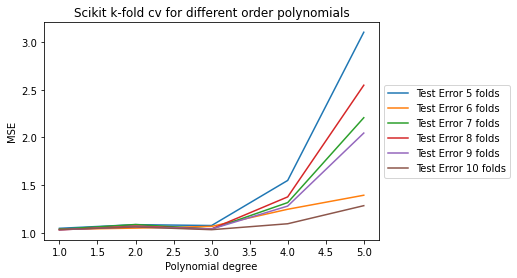

In [15]:
k_values  = [5, 6, 7, 8, 9, 10]  # Number of folds
degree_values = [1, 2, 3, 4, 5]  # Specify degree of polynomial to be fitted

plot_Kfold_scikit(features,labels , k_values, degree_values) 


#### Without noise

MSE on test-set : 
 [[0.04576671 0.03874027 0.03839682 0.03467602 0.03352505 0.03379264]
 [0.11228997 0.0684227  0.05652764 0.04264218 0.03974759 0.03686937]
 [0.01820134 0.01337367 0.01286016 0.01229501 0.01220757 0.0111079 ]
 [0.09289967 0.04102599 0.02131225 0.01729308 0.01635007 0.01698624]
 [0.13528561 0.03653383 0.02653421 0.00997742 0.00951974 0.01010605]]


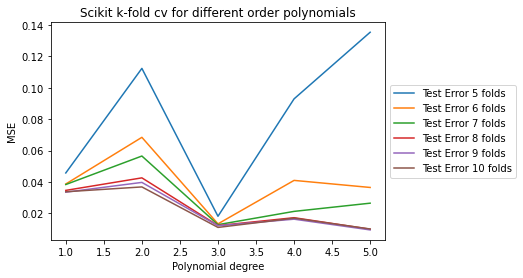

In [16]:
k_values  = [5, 6, 7, 8, 9, 10]  # Number of folds
degree_values = [1, 2, 3, 4, 5]   # Specify degree of polynomial to be fitted

plot_Kfold_scikit(features,labels , k_values, degree_values, scaling= True, add_noise= False) 
